<a href="https://colab.research.google.com/github/gprasad125/lign167_finalproject/blob/main/Copy_of_Project_Tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Multiclass Text Classification to Analyze Famous Quotes 

#### Gokul Prasad & Hoang Nguyen 
#### LIGN 167, Winter 2022

In this project, we'll aim to classify a variety of quotes with tags that refer to certain themes or elements specific to that particular quote. 

For example, Albert Einstein's quote “Life is like riding a bicycle. To keep your balance, you must keep moving.” would have tags like "life" or "simile" because it contains thematic elements about life, and contains a simile. 

In [1]:
# Scraping
import requests
from bs4 import BeautifulSoup
import time 

# Data manipulation / cleaning / visualization
import pandas as pd
import numpy as np
import gensim as gm
import nltk
from nltk.corpus import stopwords
import re 
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Sklearn modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# Scraping and Cleaning the Data 

We'll be sourcing our data from http://quotes.toscrape.com. This is a website containing 11 pages worth of quotes, each of them classified with a few tags. 

Firstly, we'll loop through the pages, and scrape the website HTML data with BeautifulSoup. Then, we'll use lambda functions to pull author data, quote data, and tag data. We'll put each of these into lists, and then create a pandas DataFrame to hold all our data. 

In [2]:
page = 1

authors_lst = []
quotes_lst = []
tags_lst = []


while page < 11: 
    url = 'http://quotes.toscrape.com/page/{}'.format(page)
    
    time.sleep(10)
    scrape = requests.get(url)
    parsed = BeautifulSoup(scrape.content, "html.parser")
    
    curr_authors = list(map(lambda x: x.text, parsed.find_all(class_ = "author")))
    curr_quotes = list(map(lambda x: x.text, parsed.find_all(class_ = 'text')))
    
    tag_groups = parsed.find_all("div", class_ = "tags")

    curr_tags = []
    for i in range(len(tag_groups)):

        tags = tag_groups[i].find_all("a", class_ = "tag")

        curr_group = []
        for tag in tags:

            curr_group.append(tag.text)

        curr_tags.append(curr_group)
    
    authors_lst += curr_authors
    quotes_lst += curr_quotes
    tags_lst += curr_tags
    
    page += 1
    
data = {"Author":authors_lst, "Quote":quotes_lst, "Tags":tags_lst}
df = pd.DataFrame(data)
df.head()

,Author,Quote,Tags
0,Albert Einstein,“The world as we have created it is a process ...,"[change, deep-thoughts, thinking, world]"
1,J.K. Rowling,"“It is our choices, Harry, that show what we t...","[abilities, choices]"
2,Albert Einstein,“There are only two ways to live your life. On...,"[inspirational, life, live, miracle, miracles]"
3,Jane Austen,"“The person, be it gentleman or lady, who has ...","[aliteracy, books, classic, humor]"
4,Marilyn Monroe,"“Imperfection is beauty, madness is genius and...","[be-yourself, inspirational]"


As we can see, our dataset contains some pretty messy strings in all 3 columns. We'll need to process the data to make sure it's usable for our modeling later on. 

For quotes, we'll first make all characters lowercase, and then use regex functionality to substitute any non alphanumeric / whitespace character with a blank string. 

For example, if we input a quote like "I love. LIGN 167!!?" we would receive an output of "i love lign 167". We'll apply this to our Author and Quote columns to clean them up and make them much more simplified strings. 

In [3]:
def quotes_cleaning(text):
    
    text = text.lower()
    
    text = re.sub('[^A-Za-z0-9\s]', '', text)
    
    return text

df['Quote'] = df['Quote'].apply(quotes_cleaning)
df['Author'] = df['Author'].apply(quotes_cleaning)

For the tags, we have to a slightly more complicated function since the data is tucked into lists. Firstly, we'll make it a string, and use regex to remove the surrounding brackets, remove non-word characters, and replace all multi-whitespaces with a single space. We'll then render the string as a list again, and return the list. 

For example, if we input a list like [deep?, wonderous.., love-happy], we would get an output of [deep, wonderous, love, happy]

In [4]:
def tags_cleaning(text):
    
    text = re.sub('[\[ \]]', ' ', str(text))
    text = re.sub('[^\w]', ' ', text)
    text = re.sub('[\s]', ' ', text)
    
    text = ' '.join(text.split())
    
    return text.split(' ')

df['Tags'] = df['Tags'].apply(tags_cleaning)

Now, having cleaned the dataset more fully, we can see the impact on our data. 

In [5]:
df.head()

,Author,Quote,Tags
0,albert einstein,the world as we have created it is a process o...,"[change, deep, thoughts, thinking, world]"
1,jk rowling,it is our choices harry that show what we trul...,"[abilities, choices]"
2,albert einstein,there are only two ways to live your life one ...,"[inspirational, life, live, miracle, miracles]"
3,jane austen,the person be it gentleman or lady who has not...,"[aliteracy, books, classic, humor]"
4,marilyn monroe,imperfection is beauty madness is genius and i...,"[be, yourself, inspirational]"


# Reshaping Data for Modeling 

Now, while the data is cleaned, we can't really model accurately when our tags are all in a list. Inputting them into our sklearn Pipelines later would not work as we would want, so we have to find a way to reshape the dataframe. Firstly, we'll need to collect the minimum and maximum amount of tags, which we do as follows. 

In [6]:
df['Tags'].apply(lambda x: len(x)).max()

11

So we see that the maximum amount of tags a quote could have would be 11 tags. So, let's generate a function that will make each list of tags equivalent by adding the necessary number of None values to make it to a list of length 11. 

For example, an input of [life, duck, nature] would yield [life, duck, nature, None, None, None, None, None, None, None, None]. 

In [7]:
def tag_to_column(tags):
    
    sub = 11 - len(tags)
        
    total = tags + [None] * sub
    return total

Now we can apply that function to our Tags column, and use pandas get_dummies() functionality to reshape our dataframe to where each tag is a column, and the column contains 1s or 0s, reflecting whether or not a particular tag is in the quote belonging to that row. 

Unfortunately, pd.get_dummies() will create some duplicates so we'll groupby and sum to combine the duplicate tag columns. 

We then combine this dataframe with our original dataframe, and drop our tags columns. We can see the finished result

In [8]:
column_renames = {0:'tag_1',1:'tag_2',2:'tag_3',3:'tag_4',4:'tag_5',5:'tag_6',6:'tag_7',7:'tag_8',8:'tag_9',9:'tag_10', 10:'tag_11',}

tags = pd.DataFrame(df['Tags'].apply(tag_to_column).tolist()).rename(columns = column_renames)

tags_df = pd.get_dummies(tags, prefix = 'tag')
tags_df = tags_df.groupby(tags_df.columns, axis=1).sum()
combined = pd.concat([df, tags_df], axis = 1).drop(columns = ['Tags'])
combined.head(3)

,Author,Quote,tag_,tag_abilities,tag_activism,tag_adulthood,tag_adventure,tag_age,tag_alcohol,tag_aliteracy,...,tag_ups,tag_value,tag_wander,tag_wisdom,tag_women,tag_world,tag_write,tag_writers,tag_writing,tag_yourself
0,albert einstein,the world as we have created it is a process o...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,jk rowling,it is our choices harry that show what we trul...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,albert einstein,there are only two ways to live your life one ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see the distribution of tags as below. 31% of our quotes only have 1 tag, while only 1% have the maximum tags possible. 

1     0.31
2     0.23
3     0.20
4     0.11
5     0.06
6     0.03
8     0.03
7     0.02
11    0.01
dtype: float64

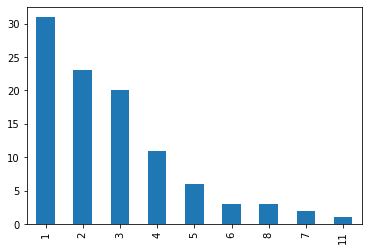

In [9]:
rowsums = combined.iloc[:,2:].sum(axis=1)
cnt = rowsums.value_counts()

cnt.plot(kind = 'bar')
cnt / cnt.sum()

# Modeling

Now, we can begin our modeling. 

Firstly, we'll get a list of all of our tags. We'll do this by taking all columns besides "Author" and "Quote"

Next, we'll use sklearn's train_test_split() function to split our dataset into a training and testing set. We'll split so that our test set is 33% of our dataset size. As we have 100 rows into our data, then we'll have a training set of 67 rows and testing size of 33 rows. 

In [ ]:
tags = combined.columns.tolist()[2:]

train, test = train_test_split(combined, random_state=42, test_size=0.33, shuffle=True)

X_train = train.Quote
X_test = test.Quote

print(X_train.shape)
print(X_test.shape)

(67,)
(33,)


### Model 1: Decision Tree Classifier

Our first model will be using scikit-learn Pipelines. 

Inside our pipeline, we'll firstly vectorize the input data by converting the quote to their TFIDF formation. This will convert our string Quotes to becoming numerical values for input. Then, we have to consider how we will be handling multiple classes. We'll try with a OneVsRest classifier, because this will allow us to pass in each tag and use an single-class estimator on each tag's train and test data. 

However, we need to wrap the OneVsRest classifier around an estimator that makes sense for what we are trying to achieve here. We'll use a Decision tree classifier, because the sklearn functionality is pretty simplistic, doesnt require much shaping of the data, and should hopefully set a good basis for our first try. 

In [ ]:
dt_classifier = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(DecisionTreeClassifier()))])

Now, we'll loop through each of the tags in our dataset, train our model on that particular tag, and then append it to a dictionary containg each tag and that tag's associated evaluation score. 

For our evaluating metric, we'll choose to use f1 scores over accuracy, because if we look at our data, we have an imbalance of tags. Some quotes have several tags, while others only have one or two. As such, using accuracy would likely not work well for this scenario. 

However, we have multiple classes, so it would not make much sense to get a bunch of f1 scores since each tag would give different results. We can instead collect each tag's precision and recall from when the model's predictions are compared to the actual test data. 

In [ ]:
accuracies = {}
for tag in tags:
    
    dt_classifier.fit(X_train, train[tag])
    prediction = dt_classifier.predict(X_test)
    
    acc = precision_recall_fscore_support(test[tag], prediction, average = 'macro')
    accuracies[tag] = acc

So now we can calculate the average precision and recall for our tags by looping through our dictionary, summing up the total of both metrics, and dividing by the number of tags.

In [ ]:
sum_precision = 0
sum_recall = 0

for key in accuracies.keys():
    
    sum_precision += accuracies[key][0]
    sum_recall += accuracies[key][1]
    
mean_precision = sum_precision / len(accuracies.keys())
mean_recall = sum_recall / len(accuracies.keys())

Now we apply the formula of finding an f1 score which is (2 * p * r) / (p + r)

In [ ]:
average_f1 = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
average_f1

0.708565482990131

So we have an f1 score of about 0.708. F1 scores range from 0 to 1, and the closer they are to 1, the better the model, so we have set up a good baseline for ourselves. But we want to improve on this and make our model better classify our quotes. 

#### Optimizing Model 1  

Now that we have our baseline model, how can we optimize it? 

There are many concepts we can implement into our Pipeline, both from a text classification standpoint, as well as a sklearn standpoint. 

The first method we'll implement is getting rid of stop-words. These are words that appear extremely frequently in human language, and give very little value to our model. Removing them can allow our model to focus more strongly on the more important data. 

In [ ]:
stop_words = set(stopwords.words('english'))

Now that we have defined the words to remove, we can try and optimize our other parameters with GridSearchCV. First, we'll need to select what parameters we can optimize. 

In [ ]:
parameters = {
    'clf':(DecisionTreeClassifier(),),
    'clf__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
    'clf__min_samples_split': [2, 3, 5, 7, 10, 15, 20],
    'clf__min_samples_leaf': [2, 3, 5, 7, 10, 15, 20]
}

Now we have created the parameters, we can place that into a GridSearchCV and train it on our data. 
Let's print out the best parameters we get. 

In [ ]:
grids = GridSearchCV(dt_classifier, param_grid = parameters, cv = 3, return_train_score = True)
for tag in tags:
    grids.fit(X_train, train[tag])

grids.best_params_

{'clf': DecisionTreeClassifier(max_depth=2, min_samples_leaf=2),
 'clf__max_depth': 2,
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 2}

Let's now re-run our training, testing, and calculating of precision and recall to calculate a new and hopefully improved average f1 score. 

In [ ]:
dt_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)), 
    ('clf', OneVsRestClassifier(DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 2)))])

accuracies = {}
for tag in tags:
    
    dt_classifier.fit(X_train, train[tag])
    prediction = dt_classifier.predict(X_test)
    
    acc = precision_recall_fscore_support(test[tag], prediction, average = 'macro')
    accuracies[tag] = acc

sum_precision = 0
sum_recall = 0

for key in accuracies.keys():
    
    sum_precision += accuracies[key][0]
    sum_recall += accuracies[key][1]
    
mean_precision = sum_precision / len(accuracies.keys())
mean_recall = sum_recall / len(accuracies.keys())

average_f1 = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
average_f1

0.771879675599829

So we see a decent improvement from 0.7 --> 0.77, achieved with GridSearchCV and stop_word inclusion to optimize our model. However, we'll take a look at other models / optimizations to see if we can get a heightened score. 

### Model 2: 

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [41]:
x = combined['Quote']
y = combined.drop(columns = ['Author', 'Quote'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

shapes = {'train':[x_train.shape, y_train.shape], 'test':[x_test.shape, y_test.shape]}
shapes

{'test': [(30,), (30, 156)], 'train': [(70,), (70, 156)]}

In [43]:
max_words = combined['Quote'].apply(lambda x: len(x)).max()
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

size_of_vocab = len(tokenizer.word_index) + 1

x_train = pad_sequences(x_train, padding='post')
x_test = pad_sequences(x_test, padding='post')

In [33]:
token_quotes = tokenizer.texts_to_sequences(combined['Quote'].values)
token_quotes = pad_sequences(token_quotes)
token_quotes.shape

(100, 198)

{'test': [(10, 198), (10, 156)], 'train': [(90, 198), (90, 156)]}

In [28]:
model = Sequential()

input_dim = token_quotes.shape[0] + 1
model.add(Embedding(input_dim, 100, input_length=token_quotes.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(156, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 198, 100)          10100     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 198, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 156)               15756     
                                                                 
Total params: 106,256
Trainable params: 106,256
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
epochs = 5
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/5


InvalidArgumentError: ignored